# `MITWindfarm` Quickstart

`MITWindfarm` is a steady-state wake solver, which couples aerodynamic rotor models based on momentum theory with turbulent far-wake models. Furthermore, rotor models can couple to blade-element momentum (BEM) theory to output realistic set points of pitch, tip-speed ratio, and yaw for wind turbine control. This tutorial will walk through setting up various run scenarios in order to gain familiarity with `MITWindfarm`.

The two most important classes for a user are the `WindFarm` class and the `WindfarmSolution` class. The `WindFarm` class allows the user to specify all of the models within a wind farm (rotor, wake, superposition, and base wind field). The wind farm layout and specific rotor settings can then be passed to the `WindFarm`, which produces a `WindFarmSolution`. This contains the solution for each rotor within the wind farm. We will begin by initializing a `WindFarm` object.

Start with installing the code from GitHub. In order to run the notebook below, you will need to install both `mitwindfarm` and `MITRotor`. Then import the code as follows:

In [57]:
from mitwindfarm import Area, AD, UnifiedAD, BEM, GaussianWakeModel, VariableKwGaussianWakeModel
from mitwindfarm import Uniform, PowerLaw, Niayifar, Layout, GridLayout, Windfarm, Plotting
from MITRotor.ReferenceTurbines import IEA15MW
from MITRotor.Momentum import UnifiedMomentum

We will also use a few common python packages.

In [58]:
import numpy as np
import matplotlib.pyplot as plt

## Initializing a `WindFarm` Object

A `WindFarm` object has 5 optional parameters, each of which help determine its function. These parameters are the: `rotor_model`, `wake_model`, `superposition`, `base_windfield`, and `TIamb`. The first 4 arguments are objects/models. Their instantiation is discussed below. `TIamb` is the ambient turbulence intensity, which is simply a float value.

Beyond the standard windfarm, there is also a `CurledWindfarm` that implements the curled wake model. See `example_08_curled_windfarm.py` to see how to use that. It follows many similar principles to the rest of this guide.

### Windfarm Flow Field

We first define the flow field through the wind farm. As of now, the `WindField` class only has two main options, the `Uniform` wind field and the `PowerLaw` wind field. For the `Uniform`, the user can provide the wind speed and the ambient turbulence intensity. For the `PowerLaw`, the user must provide a reference wind speed, as well as a height reference and exponent for the power law. They must also provide the turbulence intensity. If neither of these `WindField`s is explicitly provided to the `WindFarm` class, the `Uniform` model will be used with a wind velocity of $1 \frac{\text{m}}{\text{s}}$.

In [59]:
uniform_wind_field = Uniform(U0 = 1.0, TIamb = 0.0)
power_law_wind_field = PowerLaw(Uref = 1.0, zref = 50.0, exp = 2.0, TIamb = 0.0)

If a user wanted a new flow field type, the could define a new subclass, which would require a method to define the wind speed, turbulence intensity, and wind direction. Details can be found in the `Windfield.py` file.

### Rotor Setup

We now need to define the type of rotor model that the turbines will use. The code provides three types of rotors (which are subtypes of the `Rotor` class): `AD`, `UnifiedAD`, and `BEM`. If no rotor model is explicitly passed to the `WindFarm` model, the `AD` model will be used.

#### Actuator Disk Models

The `AD` model is implements the model presented in Heck et al (with no correction), while the `UnifiedAD` implements the  model presented in Liew et al.

For the `AD` and `UnifiedAD` models, the only argument is an optional `RotorGrid`. If none is provided, they will use default grids. The `AD` model defaults to a polar grid with 10 points along the radial direction and 10 angle increments around rotor. However, the user can also specify a polar rotor grid with more grid points. This polar grid is initialized by the `Area` function, as seen below. The `UnifiedAD` model defaults to a `Point` rotor grid, which just defines a single point at the origin. There is also a `Line` rotor grid, which is a line of points across the rotor.

In [60]:
coarse_rotor_grid = Area()
fine_rotor_grid = Area(r_disc = 40, theta_disc= 40)
rotor_ad = AD()
rotor_unified = UnifiedAD(fine_rotor_grid)

#### Blade Element Models and MITRotor

To create a blade element model (`BEM`), the user will need to use the `MITRotor` package. Using this package, the user can initialize a `BEM`. To learn more about how to create specific `BEM` rotors, see the quick start guide for `MITRotor`. Here, we will just use one of the reference turbines with all default sub-models.

In [61]:
rotor_bem = BEM(IEA15MW(), momentum_model = UnifiedMomentum())

#### `RotorSolution`

Analogously to how we are currently building a `WindFarm` object so that we can solve for a `WindFarmSolution`, a `Rotor` has a `RotorSolution`. So, if you are only interested in a single rotor solution, you can now solve for that rotor's solution, rather than building an entire wind farm, which will solve for all of the rotor's solutions together in tandem.

For the `AD` and `UniformAD` models, you need to provide a `x`, `y`, and `z` arguments that specify the location you want the solution for, measured in distance from the centroid of the rotor. You also need to provide `windfield` model, as well as `Ctprime`, `yaw`, and `tilt` values. We will later refer to `Ctprime`, `yaw`, and `tilt` as "setpoints".

Similarly, for the `BEM` model, you also need to provide `x`, `y`, `z`, and `windfield` arguments. The `BEM` setpoints, however are different: `pitch`, `tsr` (tip speed ratio), `yaw`, and `tilt`. Note that within `MITRotor`, there are a few specifications on which setups support tilt. See the `MITRotor` quickstart guide for that information.

In [62]:
ad_solution = rotor_ad(x = 0, y = 0, z = 0, windfield = uniform_wind_field, Ctprime = 2, yaw = np.deg2rad(10), tilt = np.deg2rad(5))

print(f"Control setpoints: Ctprime = {ad_solution.Ctprime:2.2f}, yaw = {ad_solution.yaw:2.2f}, tilt = {ad_solution.tilt:2.2f}")
print(f"Power coefficient: {ad_solution.Cp:2.2f}")
print(f"Thrust coefficient: {ad_solution.Ct:2.2f}")
print(f"Axial induction: {ad_solution.an:2.2f}")
print(f"Far-wake streamwise velocity: {ad_solution.u4:2.2f}")
print(f"Far-wake lateral velocity: {ad_solution.v4:2.2f}")
print(f"Rotor-effective wind speed: {ad_solution.REWS:2.2f}")
print(f"Wake turbulence intensity: {ad_solution.TI:2.2f}")

Control setpoints: Ctprime = 2.00, yaw = 0.17, tilt = 0.09
Power coefficient: 0.58
Thrust coefficient: 0.87
Axial induction: 0.33
Far-wake streamwise velocity: 0.35
Far-wake lateral velocity: -0.04
Rotor-effective wind speed: 1.00
Wake turbulence intensity: 0.00


In [63]:
bem_solution = rotor_bem(x = 0, y = 0, z = 0, windfield = uniform_wind_field, pitch = 0, tsr = 9, yaw = np.deg2rad(10), tilt = np.deg2rad(5))

print(f"Control setpoints: Ctprime = {bem_solution.Ctprime:2.2f}, yaw = {bem_solution.yaw:2.2f}, tilt = {bem_solution.tilt:2.2f}")
print(f"Power coefficient: {bem_solution.Cp:2.2f}")
print(f"Thrust coefficient: {bem_solution.Ct:2.2f}")
print(f"Local thrust coefficient: {bem_solution.Ctprime:2.2f}")
print(f"Axial induction: {bem_solution.an:2.2f}")
print(f"Far-wake streamwise velocity: {bem_solution.u4:2.2f}")
print(f"Far-wake lateral velocity: {bem_solution.v4:2.2f}")
print(f"Rotor-effective wind speed: {bem_solution.REWS:2.2f}")
print(f"Wake turbulence intensity: {bem_solution.TI:2.2f}")

Control setpoints: Ctprime = 1.80, yaw = 0.17, tilt = 0.09
Power coefficient: 0.42
Thrust coefficient: 0.73
Local thrust coefficient: 1.80
Axial induction: 0.35
Far-wake streamwise velocity: 0.54
Far-wake lateral velocity: -0.03
Rotor-effective wind speed: 1.00
Wake turbulence intensity: 0.00


### Wake Model

Within the package, there is a `WakeModel` abstract class with two concrete types: the `GaussianWakeModel` and the `VariableKwGaussianWakeModel`. Note that the curled wake model is also implemented, but requires a different type of wind farm, a `CurledWindfarm`, due to different solving methods. See `example_08_curled_windfarm.py` for more information.

The `GaussianWakeModel` has the following optional arguments (and default values): `sigma` (0.25), `kw` (0.07), `WATI_sigma_multiplier` (1.0), and `xmax` (100.0).

On the other hand, the `VariableKwGaussianWakeModel` adjusts the wake spreading rate based on the
`Ctprime` and the `TI` experienced by the wake-generating turbine based on the linear relationship: $kw = a * TI + b * C_T' + c$. Therefore, `VariableKwGaussianWakeModel` has the following optional arguments (and default values): `a`, `b`, `c`, `sigma` ($\frac{1}{\sqrt{8}}$), `WATI_sigma_multiplier`(1.0), and `xmax` (100.0).

If neither of these is explicitly provided to the `WindFarm` model, the `GaussianWakeModel` is used.

In [64]:
gaussian_wake_model = GaussianWakeModel()
variable_gaussian_wake_model = VariableKwGaussianWakeModel(a = 1, b = 1, c = 1)

To learn to visualize the wakes, see `example_03_wake.py`.

### Superposition

The superposition model determines how the generated wakes are superimposed onto the wind flow field. There is a `Superposition` abstract class, with four concrete subclasses: `Linear`, `Niayifar`, `Quadratic`, and `Dominant`. None of these take any arguments. If none of these is explicitly provided to `WindFarm` constructor, the `Niayifar` superposition model will be used by default.

In [65]:
niayifar_superposition = Niayifar()

To visualize the difference between the different superpostion methods, run `example_04_superposition.py`.

### `WindFarm` Model

We can now put all of these pieces together to build a `WindFarm` model.

In [66]:
windfarm_unified_bem = Windfarm(rotor_model = rotor_bem,
                               wake_model = gaussian_wake_model,
                               superposition = niayifar_superposition,
                               base_windfield = uniform_wind_field,
                               TIamb = 0.0
                               )

## Calculating a `WindFarmSolution`

Once the user has created a `WindFarm` object, they can pass it two arguments, a `layout` and `setpoints`, to find a solution for the specified wind farm.

### Wind Farm `Layout`

You can now set up the layout of your wind farm. You can create a vector for the x-coordinates (`xs`) and y-coordinates (`ys`) of the rotor. There is also an optional z-coordinate input (`zs`), which allows you to give the rotors different elevations. If it isn't set, then the rotors are all at the same elevation.

You can also rotate a `Layout`. By default, the `Layout` is rotated around the centroid of the group of turbines, and rotated by degrees. However, rotating around the origin and rotating by radians is also possible, as seen below.

In [67]:
xs = [0, 0, 1, 1]
ys = [0, 1, 0, 1]

layout = Layout(xs, ys)
rot_centroid_layout = layout.rotate(20)  # rotated 20 degrees around the centroid of the turbines.
rot_origin_layout = layout.rotate(np.deg2rad(20), "rad", "origin")  # rotated the origin of the turbines.

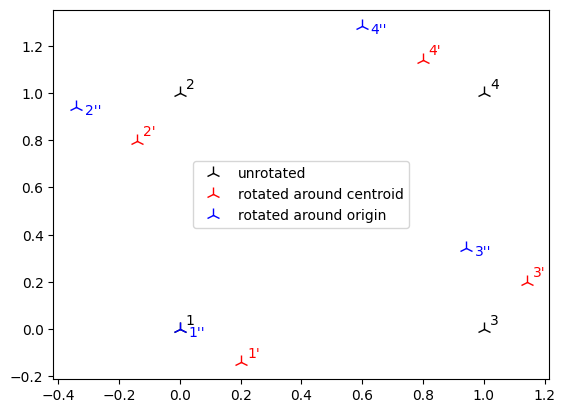

In [68]:
plt.plot(layout.x, layout.y, "2k", ms=10, label="unrotated")
plt.plot(rot_centroid_layout.x, rot_centroid_layout.y, "2r", ms=10, label="rotated around centroid")
plt.plot(rot_origin_layout.x, rot_origin_layout.y, "2b", ms=10, label="rotated around origin")

for i, (x, y, z) in enumerate(layout):
    plt.text(x + 0.02, y + 0.02, f"{i+1}", color = "k")

for i, (x, y, z) in enumerate(rot_centroid_layout):
    plt.text(x + 0.02, y + 0.02, f"{i+1}'", color = "r")

for i, (x, y, z) in enumerate(rot_origin_layout):
    plt.text(x + 0.03, y - 0.03, f"{i+1}''", color = "b")

plt.legend(loc = "center");

If you're interested in initializing an entire grid of turbines, you're can specify the grid layout with the `GridLayout` function. With this function, you can specify the spacing and number of turbines in both the streamwise and spanwise directions (`Sx`, `Sy`, `Nx`, and `Ny`). You can also specify a y-`offset`, which ranges between 0 and 1 (default is 0). Finally, you can specify the `shape` of the layout, which can either be `stag` or `trap` (default is `trap`). We can see two examples below. Note that these `GridLayouts` can also be rotated.

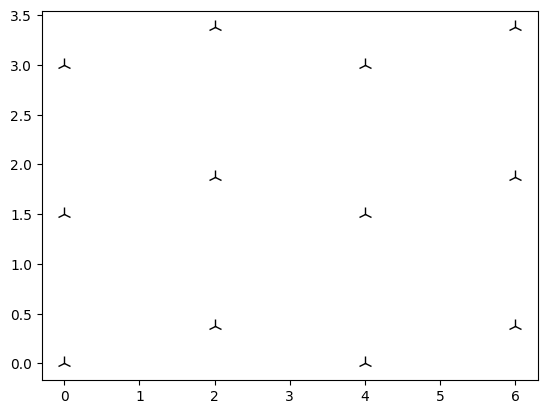

In [69]:
stag_grid_layout = GridLayout(Sx=2.0, Sy=1.5, Nx=4, Ny=3, offset = 0.5, shape="stag")
plt.plot(stag_grid_layout.x, stag_grid_layout.y, "2k", ms=10);

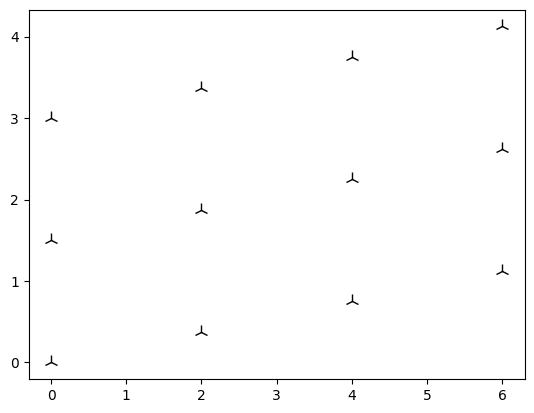

In [70]:
trap_grid_layout = GridLayout(Sx=2.0, Sy=1.5, Nx=4, Ny=3, offset = 0.5, shape="trap")
plt.plot(trap_grid_layout.x, trap_grid_layout.y, "2k", ms=10);

### Wind Farm `setpoints`

Setpoints are properties specific to the rotor model. For both the `AD` and `UnifiedAD` models, the `setpoints` are `Ctprime`, `yaw`, and `tilt`. For `BEM`, the `setpoints` are `pitch`, `tsr`, and `yaw`, and `tilt`. A tuple of setpoints must be provided for each turbine in a wind farm, in the form of a vector of tuples.

In [71]:
bem_setpoints = [(0, 7, 0, 0) for i in range(len(stag_grid_layout))]

### `WindFarmSolution`

We can now put together all of pieces we previously instantiated and visualize the wake produced.

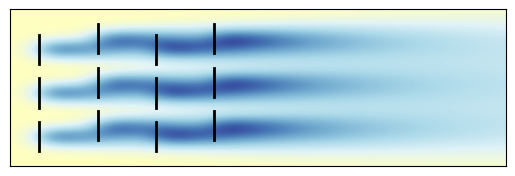

In [72]:
windfarm_solution = windfarm_unified_bem(stag_grid_layout, bem_setpoints)

fig, ax = plt.subplots()
Plotting.plot_windfarm(windfarm_solution, ax)

For more examples of using `MITWindFarm`, including for yaw optimization, see `example_05_basic_windfarm.py`, `example_06_yaw_optimisation.py`, and `example_07_BEM_yaw_optimization.py`.